In [97]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict
from datetime import datetime
from scipy.io import loadmat

In [ ]:
# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_raw = pd.read_excel(file_path, sheet_name=excel_sheet_name)

# Extract AAL source names
cser_values = loadmat("cser_values.mat")
source_names = [(cser_values['source_names'][i][0][0]) for i in range(60)]

# Load EEG source data from -v7.3 .mat file
eeg_source = h5py.File('eeg_source.mat', 'r')
eeg_source_open = eeg_source['eeg_source_open']
eeg_source_closed = eeg_source['eeg_source_closed']

In [4]:
# Prep separated from calculation because np calls slow down after importing LZ76

def lzc_prep(eeg_source):
    
    all_subjects = {}

    for i, (key, subj_data) in enumerate(eeg_source.items()):
        if i % 20 == 0:
            print(f"Processing {i+1}/{len(eeg_source)}")

        key = key[1:]    
        subj_data = np.array(subj_data)  # shape: (samples, sources, trials)
        subj_srcs = []

        for src in range(60):
            # Reshape: concatenate across trials for the current source
            data_1d = subj_data[:, src, :].reshape(-1)

            # Standardize (zero mean, unit variance)
            data_1d = (data_1d - np.mean(data_1d)) / np.std(data_1d)
            
            # Binarize by median thresholding
            threshold = np.median(data_1d)
            binary_seq = (data_1d > threshold).astype(int)

            # Split into 4s epochs (sr = 500Hz)
            segment_length = 4 * 500
            n_segments = len(binary_seq) // segment_length
            subj_segments = [binary_seq[i*segment_length:(i+1)*segment_length] for i in range(n_segments)]

            subj_srcs.append(subj_segments)

        all_subjects[key] = subj_srcs

    print()
    return all_subjects


prep_open = lzc_prep(eeg_source_open)
prep_closed = lzc_prep(eeg_source_closed) 

Processing 1/119
Processing 21/119
Processing 41/119
Processing 61/119
Processing 81/119
Processing 101/119

Processing 1/119
Processing 21/119
Processing 41/119
Processing 61/119
Processing 81/119
Processing 101/119



In [5]:
# Took 588 minutes = 9.8 hours

from lz76.lz76 import LZ76


def compute_lz76_er(prep_data):
    
    lz76_per_subject_source = {}
    er_per_subject_source = {}

    for i, (key, subj) in enumerate(prep_data.items()):
        subj_sources_lz = []
        subj_sources_er = []

        print(f"Processing subject {i+1}/{len(prep_data)}")

        for src in subj:         
            # Calculating LZC and ER per subject/source/segment
            src_seg_lz = [LZ76(seg) for seg in src if len(seg) > 0]
            src_seg_er = [lz * np.log2(len(seg)) / len(seg) for lz, seg in zip(src_seg_lz, src) if len(seg) > 0]

            # Calculating LZC and ER per subject/source
            subj_sources_lz.append(np.nanmean(src_seg_lz))
            subj_sources_er.append(np.nanmean(src_seg_er))
        
        lz76_per_subject_source[key] = subj_sources_lz
        er_per_subject_source[key] = subj_sources_er

    print()

    return lz76_per_subject_source, er_per_subject_source


# prep_open_test = {k: prep_open[k] for k in list(prep_open.keys())[:2]}

(lz76_subject_source_open, er_subject_source_open) = compute_lz76_er(prep_open)
(lz76_subject_source_closed, er_subject_source_closed) = compute_lz76_er(prep_closed)

Processing subject 1/119
Processing subject 2/119
Processing subject 3/119
Processing subject 4/119
Processing subject 5/119
Processing subject 6/119
Processing subject 7/119
Processing subject 8/119
Processing subject 9/119
Processing subject 10/119
Processing subject 11/119
Processing subject 12/119
Processing subject 13/119
Processing subject 14/119
Processing subject 15/119
Processing subject 16/119
Processing subject 17/119
Processing subject 18/119
Processing subject 19/119
Processing subject 20/119
Processing subject 21/119
Processing subject 22/119
Processing subject 23/119
Processing subject 24/119
Processing subject 25/119
Processing subject 26/119
Processing subject 27/119
Processing subject 28/119
Processing subject 29/119
Processing subject 30/119
Processing subject 31/119
Processing subject 32/119
Processing subject 33/119
Processing subject 34/119
Processing subject 35/119
Processing subject 36/119
Processing subject 37/119
Processing subject 38/119
Processing subject 39

In [ ]:
# Turn lz76_subject_source_open from a single-level dictionary to a two-level dictionary
def turn_to_two_level_dict(subject_source):
    two_level_dict = {}
    for subj, values in subject_source.items():
        two_level_dict[subj] = {f'src{i+1:02d}_{source_names[i]}': value for i, value in enumerate(values)}
    return two_level_dict


# lz76_subject_source_open = turn_to_two_level_dict(lz76_subject_source_open)
# lz76_subject_source_closed = turn_to_two_level_dict(lz76_subject_source_closed)
# er_subject_source_open = turn_to_two_level_dict(er_subject_source_open)
# er_subject_source_closed = turn_to_two_level_dict(er_subject_source_closed)

In [64]:
region_map = {
    'frontal': list(range(2, 16)) + list(range(18, 24)),
    'occipital': list(range(24, 36)),
    'parietal': list(range(38, 50)),
    'sensorimotor': [0, 1, 16, 17, 36, 37],
    'temporal': list(range(50, 60))
}


def calculate_subject_region_averages(subject_source):
    # Calculate averages for each subject-region pair
    subject_region_averages = {}
    for subj, subj_srcs in subject_source.items():
        region_averages = {}
        for region, indices in region_map.items():
            # Calculate the mean for each region across sources
            region_values = [subj_srcs[f'src{i+1:02d}_{source_names[i]}'] for i in indices]
            region_averages[region] = np.nanmean(region_values)
        subject_region_averages[subj] = region_averages
    return subject_region_averages


def calculate_averages_nested_dict(subject_items):
    averages = defaultdict(list)
    for items in subject_items.values():
        for item, value in items.items():
            averages[item].append(value)
    for item in averages:
        averages[item] = np.nanmean(averages[item])
    return dict(averages)


def calculate_averages(subject_source_open, subject_source_closed):
    # Calculate averages for each subject across sources
    subject_open = {key: np.nanmean(list(subject_source_open[key].values())) for key in subject_source_open.keys()}
    subject_closed = {key: np.nanmean(list(subject_source_closed[key].values())) for key in subject_source_closed.keys()}

    # Calculate averages for each subject across regions
    subject_region_open = calculate_subject_region_averages(subject_source_open)
    subject_region_closed = calculate_subject_region_averages(subject_source_closed)
            
    dict = {
        'open': {
            'per_subject_source': subject_source_open,
            'per_subject_region': subject_region_open,
            'per_subject': subject_open,
            'per_source': calculate_averages_nested_dict(subject_source_open),
            'per_region': calculate_averages_nested_dict(subject_region_open),
            'overall': np.nanmean(list(subject_open.values()))
        },
        'closed': {
            'per_subject_source': subject_source_closed,
            'per_subject_region': subject_region_closed,
            'per_subject': subject_closed,
            'per_source': calculate_averages_nested_dict(subject_source_closed),
            'per_region': calculate_averages_nested_dict(subject_region_closed),
            'overall': np.nanmean(list(subject_closed.values()))
        }
    }
    
    return dict


lz76_values = calculate_averages(lz76_subject_source_open, lz76_subject_source_closed)
er_values = calculate_averages(er_subject_source_open, er_subject_source_closed)

In [ ]:
# Save the results to pickle files
with open('lz76_values.pkl', 'wb') as f:
    pickle.dump(lz76_values, f)

with open('er_values.pkl', 'wb') as f:
    pickle.dump(er_values, f)

In [ ]:
# Load the results from pickle file
lz76_values = None
with open('lz76_values.pkl', 'rb') as f:
    lz76_values = pickle.load(f)

er_values = None
with open('er_values.pkl', 'rb') as f:
    er_values = pickle.load(f)

In [67]:
def create_eyes_dict(values, eyes, label):

    values_eyes = values[eyes]

    eyes_dict = []

    # average per eyes/health condition per subject/source
    for subj_id, subj_val in values_eyes['per_subject_source'].items():
        for src_name, val in subj_val.items():
            eyes_dict.append({
                'id': subj_id,
                'eyes': eyes,
                'area': src_name,
                label: val
            })
    
    # average per eyes/health condition per subject/region
    for subj_id, subj_val in values_eyes['per_subject_region'].items():
        for region, val in subj_val.items():
            eyes_dict.append({
                'id': subj_id,
                'eyes': eyes,
                'area': region,
                label: val
            })

    # average per eyes/health condition per subject
    for subj_id, val in values_eyes['per_subject'].items():
        eyes_dict.append({
            'id': subj_id,
            'eyes': eyes,
            'area': 'brain',
            label: val
        })
    
    # average per eyes/health condition per source
    for src_name, val in values_eyes['per_source'].items():
        eyes_dict.append({
            'id': 'average',
            'eyes': eyes,
            'area': src_name,
            label: val
        })
    
    # average per eyes/health condition per region
    for region_name, val in values_eyes['per_region'].items():
        eyes_dict.append({
            'id': 'average',
            'eyes': eyes,
            'area': region_name,
            label: val
        })

    # average per eyes/health condition overall
    eyes_dict.append({
        'id': 'average',
        'eyes': eyes,
        'area': 'brain',
        label: values_eyes['overall']
    })
    
    return eyes_dict


lzc_dictionary = []
lzc_dictionary.extend(create_eyes_dict(lz76_values, 'open', 'lz76'))
lzc_dictionary.extend(create_eyes_dict(lz76_values, 'closed', 'lz76'))
lzc_df = pd.DataFrame(lzc_dictionary)

er_dictionary = []
er_dictionary.extend(create_eyes_dict(er_values, 'open', 'er'))
er_dictionary.extend(create_eyes_dict(er_values, 'closed', 'er'))
er_df = pd.DataFrame(er_dictionary)

# Merge lzc_df with er_df on 'id', 'eyes', and 'area'
lzc_er_df = pd.merge(lzc_df, er_df, on=['id', 'eyes', 'area'], how='outer')

df_raw['id'] = df_raw['id'].astype(str)
df = pd.merge(lzc_er_df, df_raw, on='id', how='left')

In [68]:
# Drop CUSTOM outliers from the DataFrame if they exist
outlier_ids = ['527','535']
# 527 > closed epochs (channels 2, 40, 54) behaves like a random walk according to MVGC
# 535 > open epochs are too noisy
ids_in_df = df['id'].astype(str).isin(outlier_ids)
if ids_in_df.any():
    df = df[~ids_in_df]
print("\nDropped outliers with IDs:", outlier_ids)


Dropped outliers with IDs: ['527', '535']


In [ ]:
df['depressed'] = df['MDD'].apply(lambda x: 1 if x <= 2 else 0)
df['intercept'] = 1
df['age_squared'] = df['age'] ** 2
if df['sex'].max() == 2:
    df['sex'] = df['sex'] - 1

variables = ['intercept', 'depressed', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'sex', 'age', 'age_squared']

# Perform regression analysis for each combination of eyes, area, and band
def perform_rlm(df, target):
    rlm_results = pd.DataFrame(columns=['eyes', 'area', 'variable', 'p_value', 't_value', 'p_significant', 't_significant'])

    for eyes in ['open', 'closed']:
        for area in df['area'].unique():
            # Run sm.RLM for each subset of the DataFrame
            subset = df[(df['eyes'] == eyes) & (df['area'] == area)]
            if subset.empty:
                continue
            model = sm.RLM(subset[target], subset[variables], missing='drop', M=sm.robust.norms.HuberT())
            results = model.fit()
            # print(results.summary())
            for var in variables[1:]:
                p_significant = results.pvalues[var] <= 0.05
                t_significant = abs(results.tvalues[var]) >= 1.7
                new_permutation = pd.DataFrame([{
                    'eyes': eyes,
                    'area': area,
                    'variable': var,
                    'p_value': results.pvalues[var],
                    't_value': results.tvalues[var],
                    'p_significant': p_significant,
                    't_significant': t_significant
                }])
                rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)
    
    return rlm_results

rlm_lz76 = perform_rlm(df, 'lz76')
# rlm_er = perform_rlm(df, 'er')


C:\Users\lukad\AppData\Local\Temp\ipykernel_16068\3333862142.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)


## TEXT SUMMARIES

In [125]:
lz76_mean_area = df.groupby(['eyes', 'depressed', 'area'])['lz76'].mean().reset_index()
lz76_mean_area_pivot = lz76_mean_area.pivot_table(index=['eyes', 'depressed'], columns=['area'], values='lz76')
print(lz76_mean_area_pivot)

area                   brain     frontal   occipital    parietal  \
eyes   depressed                                                   
closed 0          137.045404  142.687396  128.047006  127.843107   
       1          142.933789  148.161847  135.362982  133.956985   
open   0          144.787658  150.992291  138.485898  133.486810   
       1          150.886581  156.920743  145.627500  139.824148   

area              sensorimotor  src01_Precentral_L  src02_Precentral_R  \
eyes   depressed                                                         
closed 0            137.523207          134.315299          133.698517   
       1            143.369941          140.622349          139.831728   
open   0            143.922983          142.045457          139.735856   
       1            149.274772          147.684622          146.202637   

area              src03_Frontal_Sup_L  src04_Frontal_Sup_R  \
eyes   depressed                                             
closed 0              

In [126]:
er_mean_area = df.groupby(['eyes', 'depressed', 'area'])['er'].mean().reset_index()
er_mean_area_pivot = er_mean_area.pivot_table(index=['eyes', 'depressed'], columns=['area'], values='er')
print(er_mean_area_pivot)

area                 brain   frontal  occipital  parietal  sensorimotor  \
eyes   depressed                                                          
closed 0          0.751405  0.782340   0.702068  0.700950      0.754025   
       1          0.783691  0.812355   0.742181  0.734472      0.786082   
open   0          0.793855  0.827874   0.759303  0.731894      0.789114   
       1          0.827295  0.860380   0.798460  0.766641      0.818457   

area              src01_Precentral_L  src02_Precentral_R  src03_Frontal_Sup_L  \
eyes   depressed                                                                
closed 0                    0.736436            0.733055             0.759659   
       1                    0.771017            0.766682             0.790461   
open   0                    0.778820            0.766157             0.809802   
       1                    0.809739            0.801613             0.849678   

area              src04_Frontal_Sup_R  src05_Frontal_Sup_Orb_L

## PLOTS

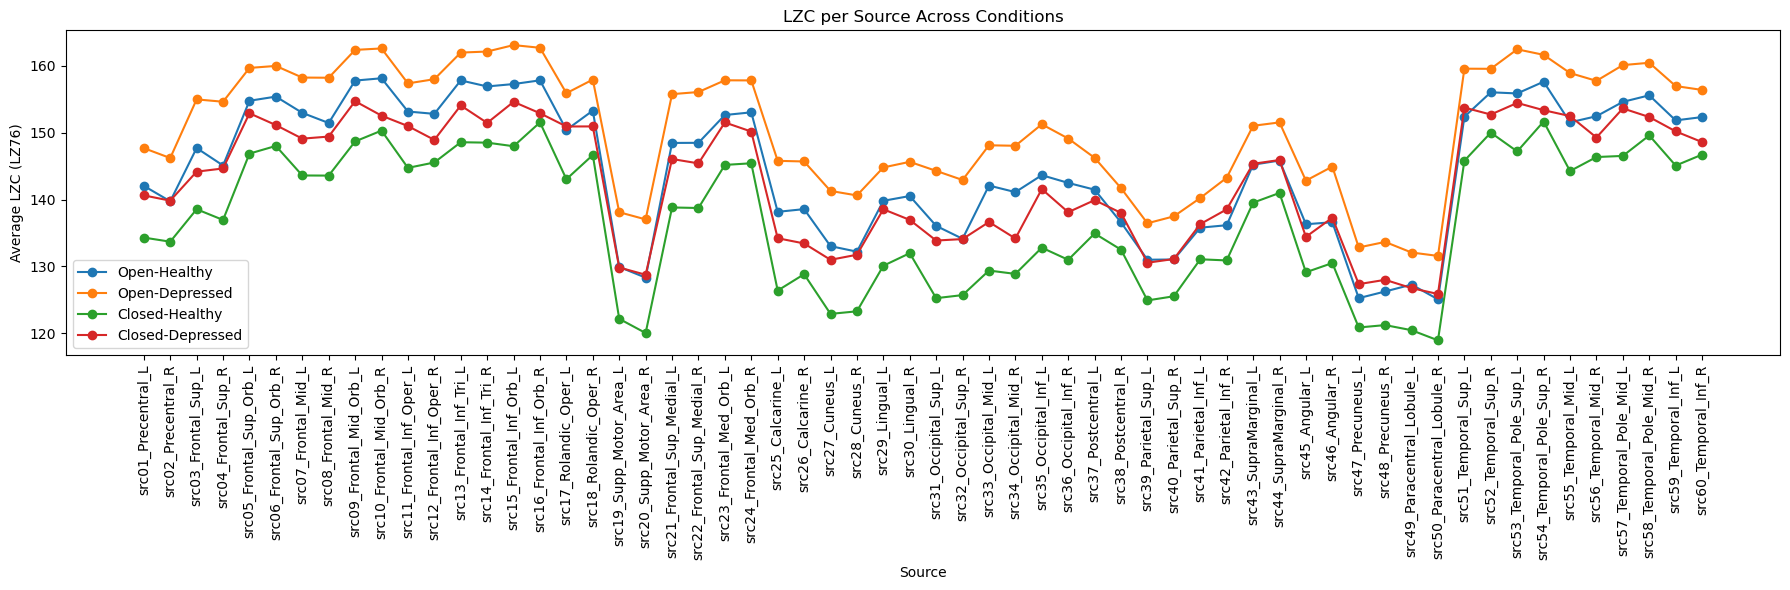

In [127]:
source_indices = np.arange(1, 61)
plt.figure(figsize=(18, 6))

for eyes in ['open', 'closed']:
    for depressed in df['depressed'].unique():
        mask = (
            (df['eyes'] == eyes) &
            (df['depressed'] == depressed) &
            (df['area'].str.startswith('src'))
        )
        area_vals = df.loc[mask, ['area', 'lz76']].groupby('area')['lz76'].mean()
        # Ensure order matches source_indices/source_names
        vals = [area_vals.get(f'src{idx+1:02d}_{source_names[idx]}', np.nan) for idx in range(60)]
        vals = np.array(vals)
        label = f'{eyes.capitalize()}-{"Depressed" if depressed == 1 else "Healthy"}'
        plt.plot(source_indices, vals, marker='o', label=label)

plt.xticks(source_indices, [f'src{idx+1:02d}_{source_names[idx]}' for idx in range(60)], rotation=90)
plt.xlabel('Source')
plt.ylabel('Average LZC (LZ76)')
plt.title('LZC per Source Across Conditions')
plt.legend()
plt.tight_layout()
plt.show()

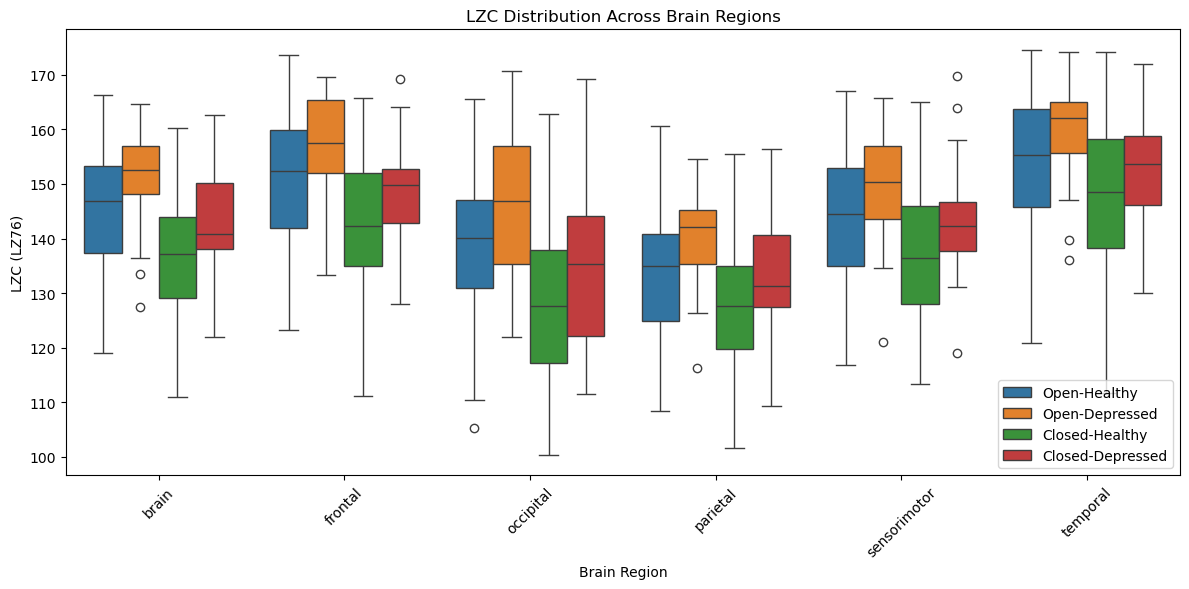

In [130]:
# Plotting LZC distribution across brain regions
mask = (df['id'] != 'average') & (~df['area'].str.startswith('src'))
df_subset = df.loc[mask, ['area', 'lz76', 'eyes', 'depressed']].copy()
df_subset['eyes'] = df_subset['eyes'].str.capitalize()
df_subset['depressed'] = df_subset['depressed'].map({0: 'Healthy', 1: 'Depressed'})
df_subset['condition'] = df_subset['eyes'] + '-' + df_subset['depressed']

df_subset['condition'] = pd.Categorical(df_subset['condition'], 
                                        categories=['Open-Healthy', 'Open-Depressed', 'Closed-Healthy', 'Closed-Depressed'],
                                        ordered=True)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_subset, x='area', y='lz76', hue='condition')

plt.xlabel('Brain Region')
plt.ylabel('LZC (LZ76)')
plt.title('LZC Distribution Across Brain Regions')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

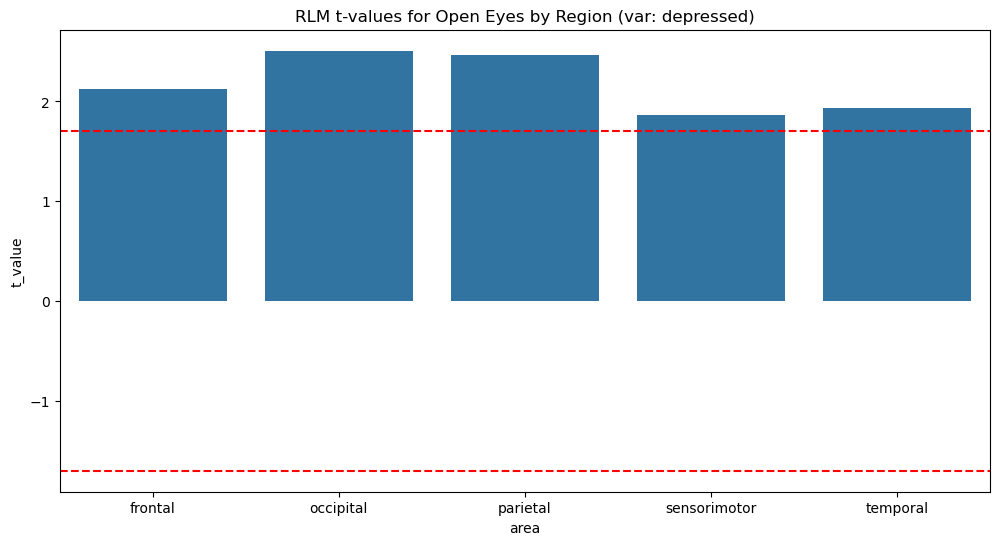

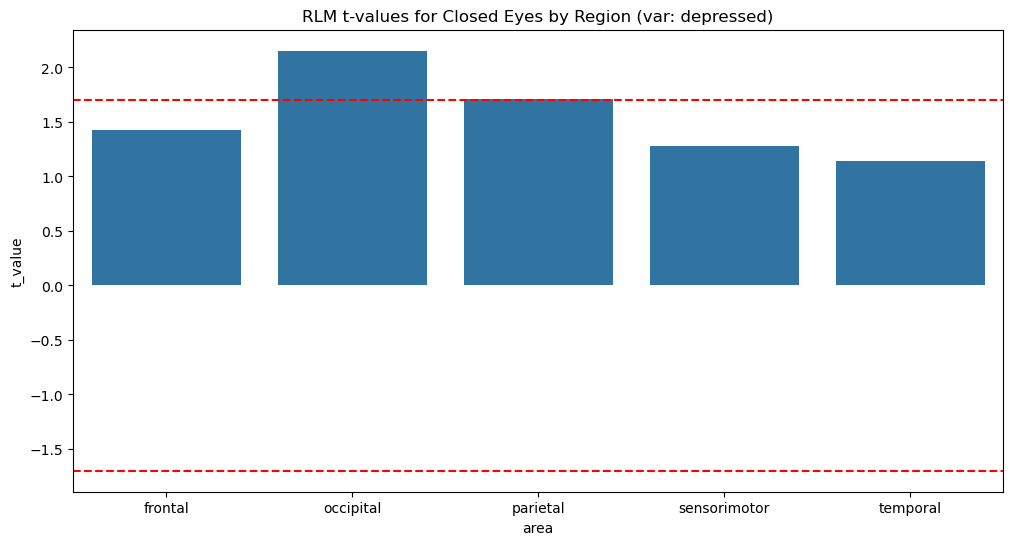

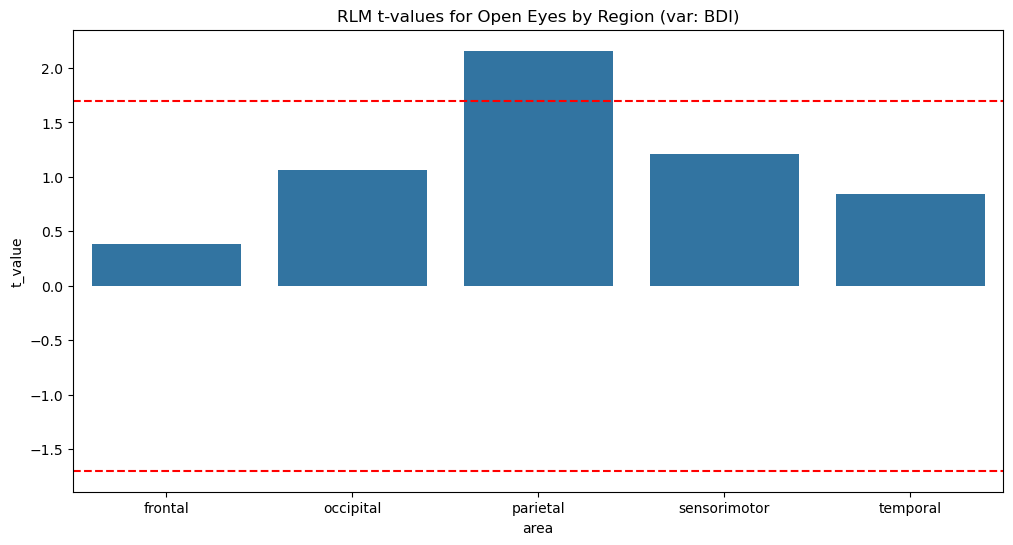

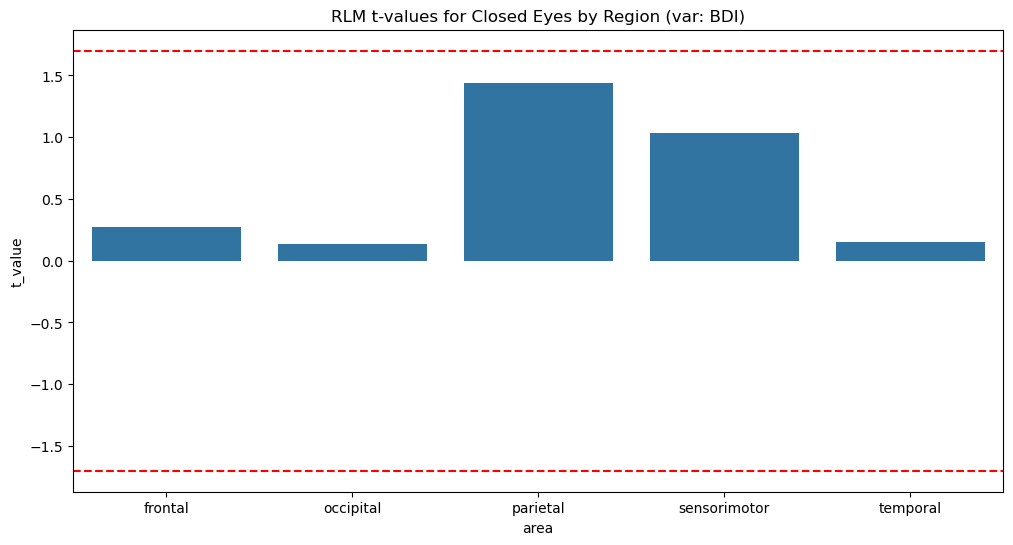

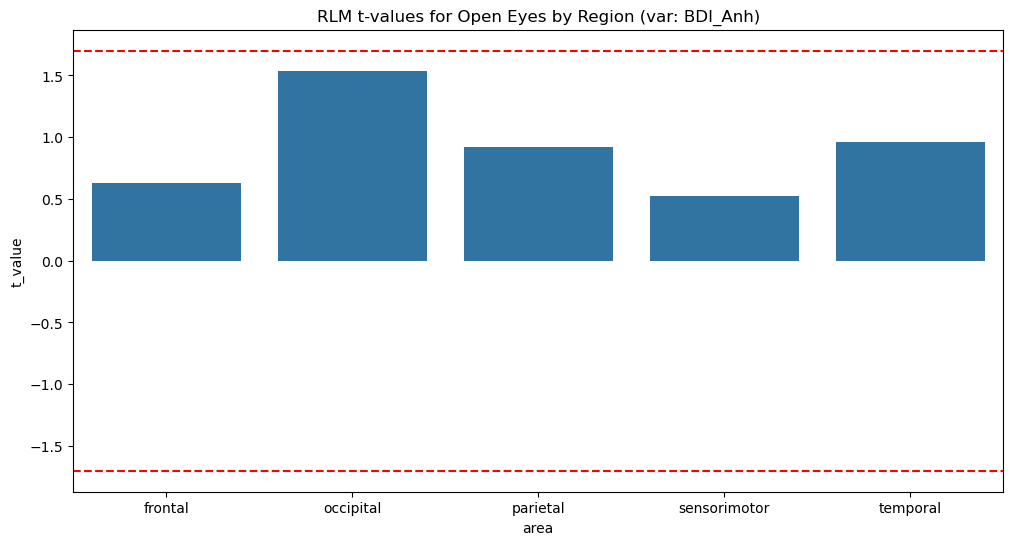

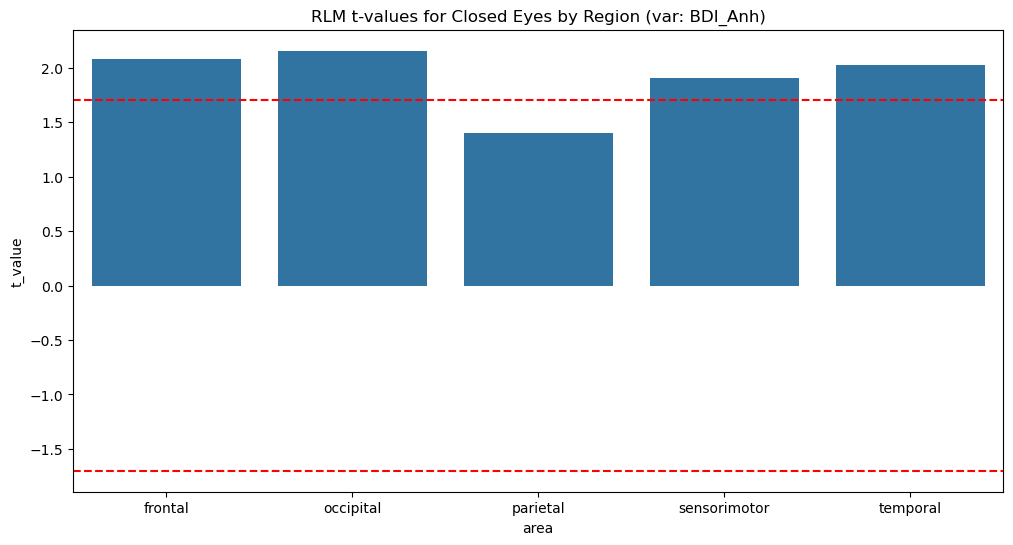

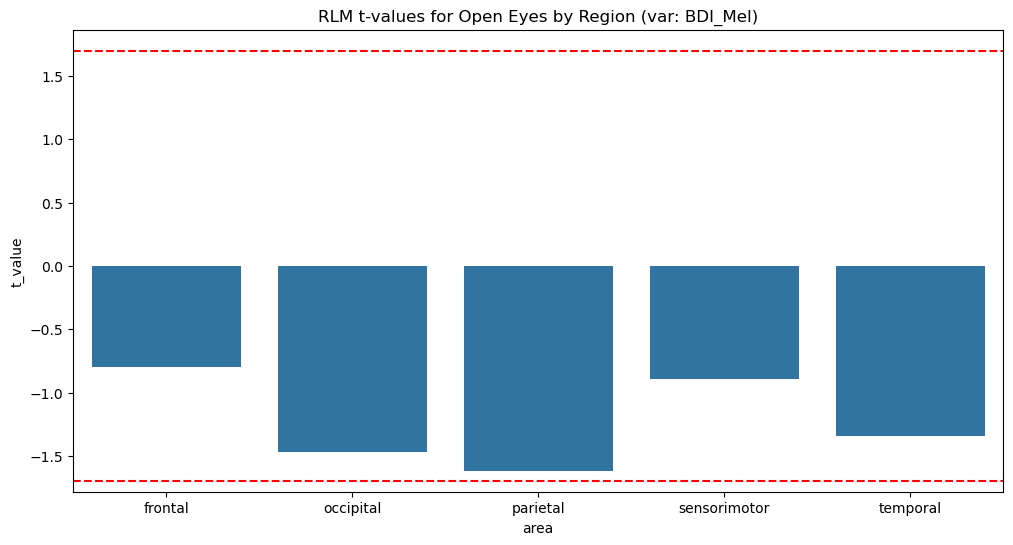

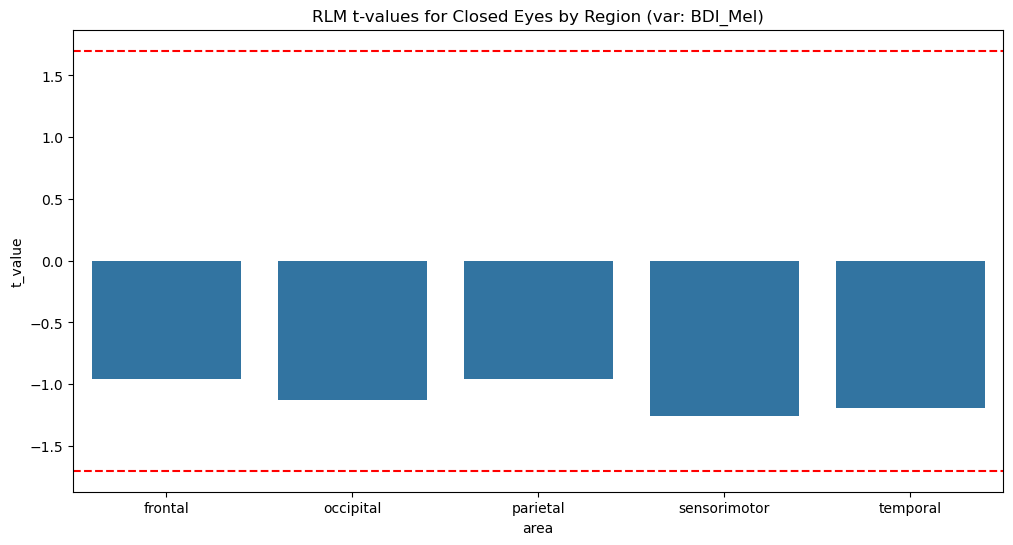

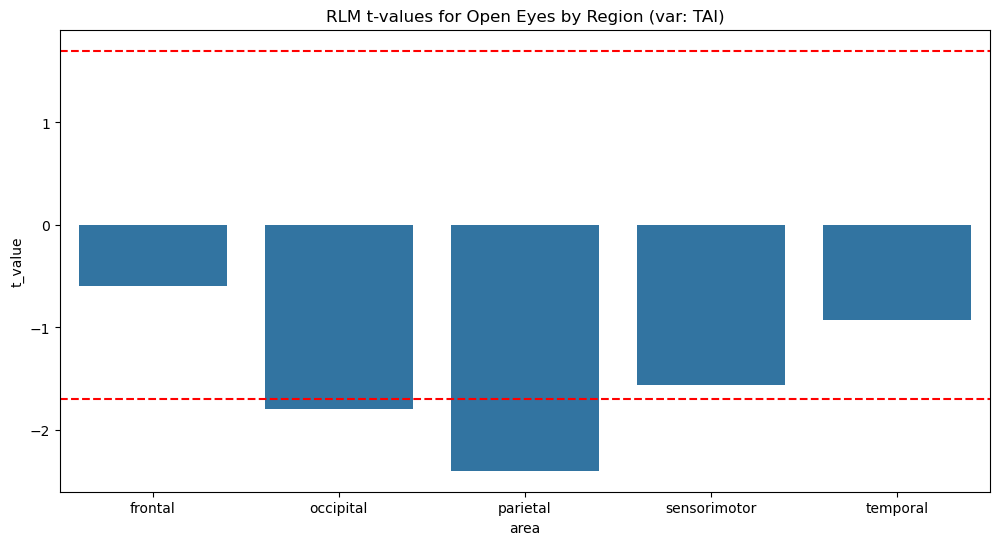

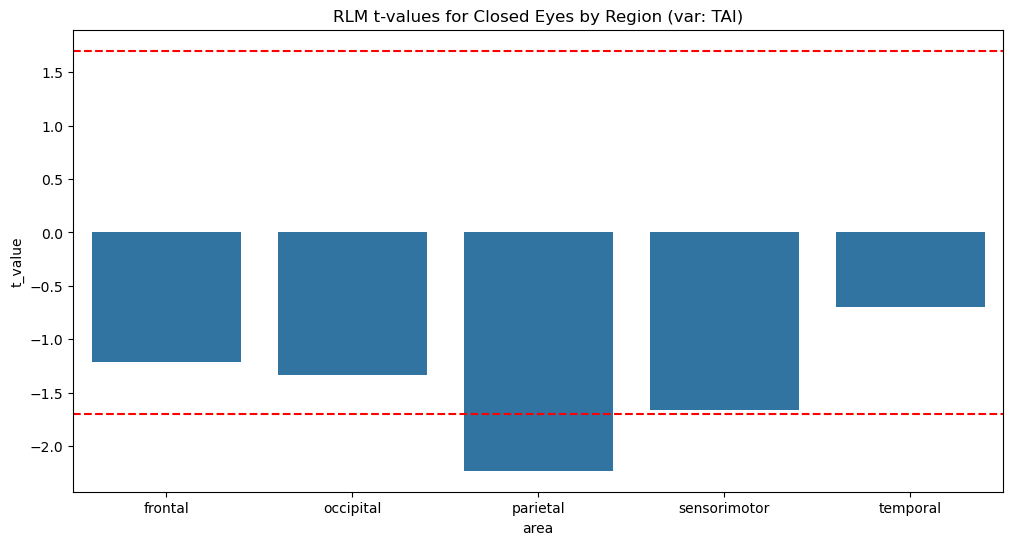

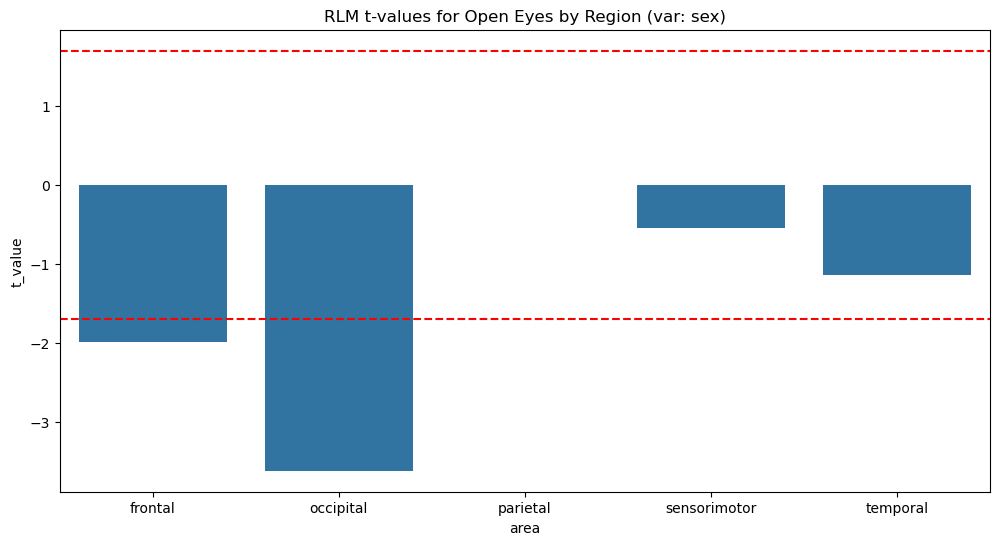

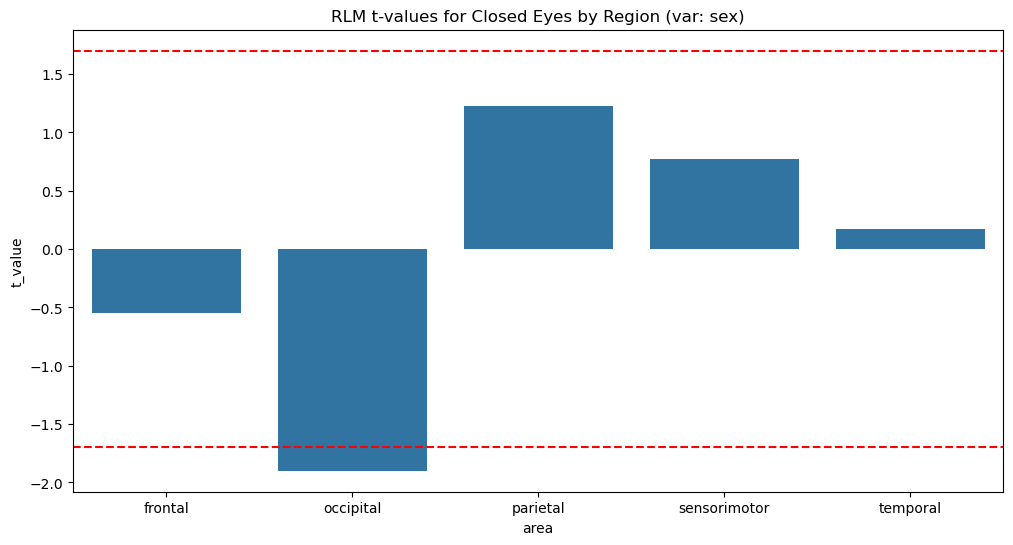

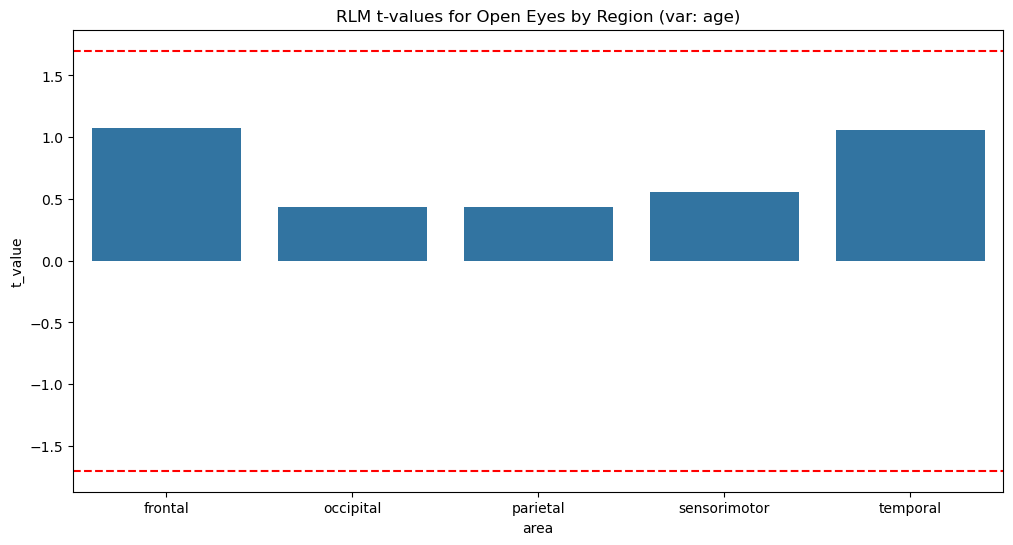

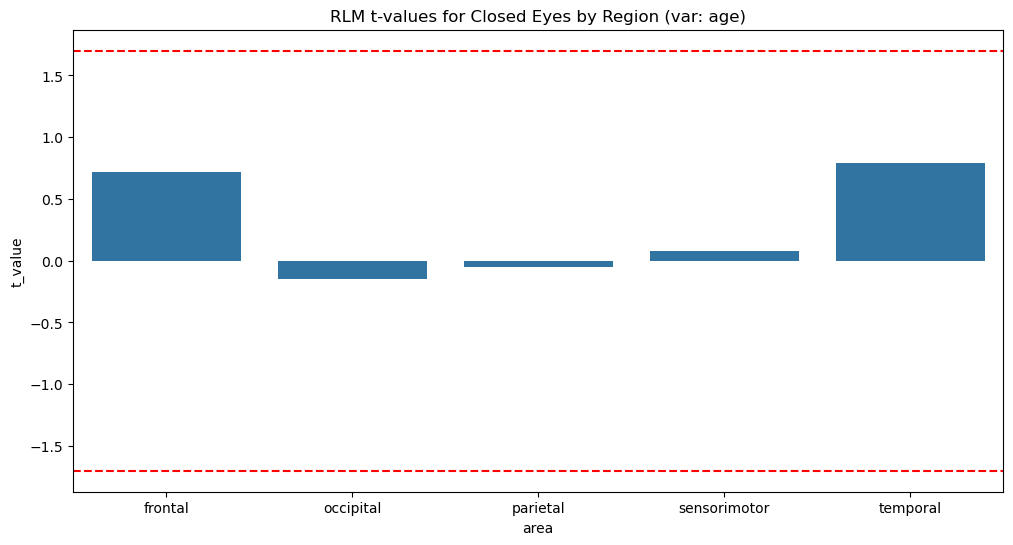

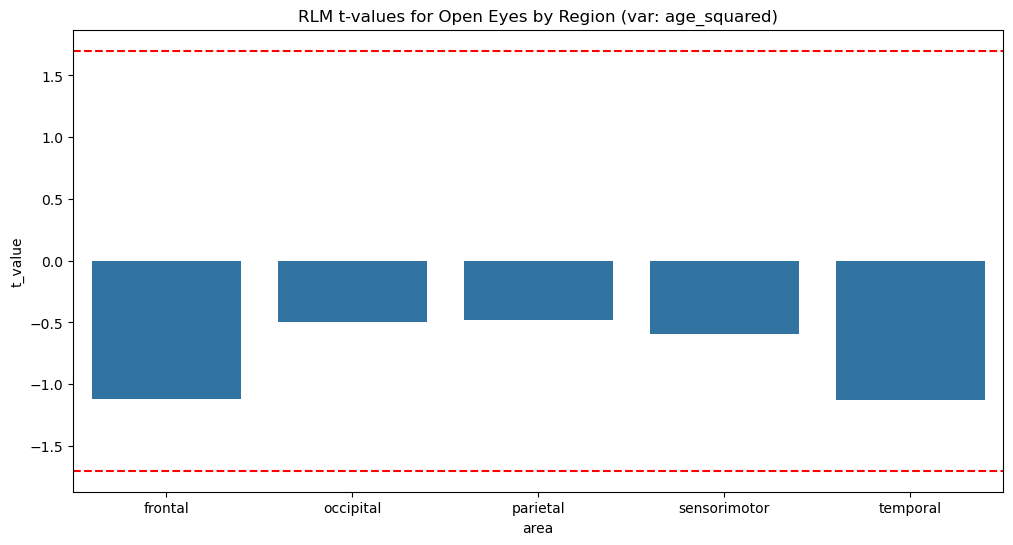

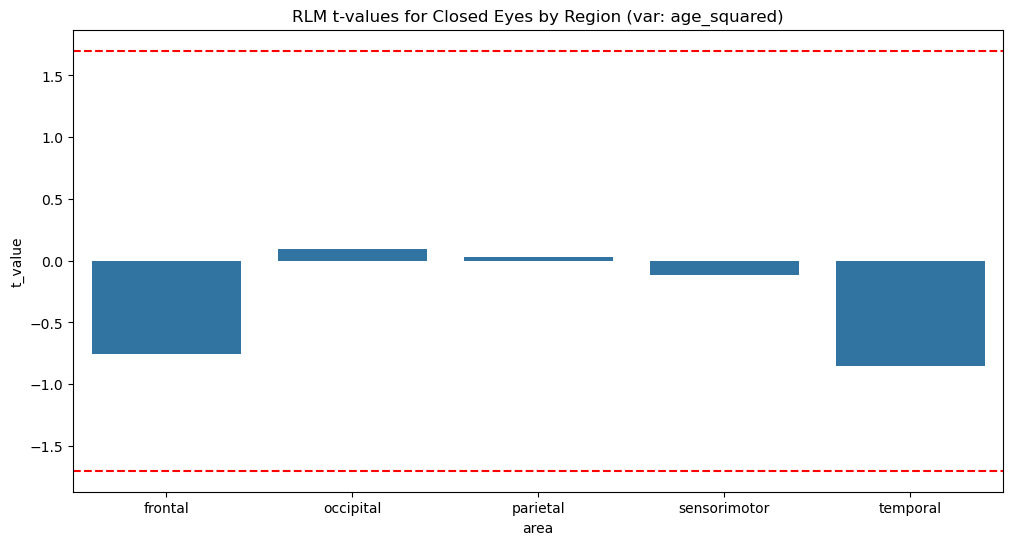

In [131]:
def barplot_significance(eyes, var):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rlm_lz76[(rlm_lz76['eyes'] == eyes) & (rlm_lz76['variable'] == var) & (rlm_lz76['area'].isin(region_map.keys()))],
                x='area', y='t_value', errorbar=None)
    plt.title(f'RLM t-values for {str.capitalize(eyes)} Eyes by Region (var: {var})')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.show()

for var in variables:
    if var in ['intercept']:
        continue
    barplot_significance('open', var)
    barplot_significance('closed', var)

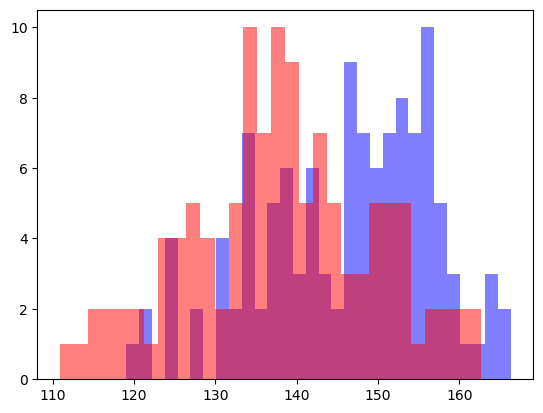

In [94]:
# Plot the distribution of LZ76 values with eyes set to 'open' and 'closed'
mask_open = (df['eyes'] == 'open') & (df['area'] == 'brain')
mask_closed = (df['eyes'] == 'closed') & (df['area'] == 'brain')

plt.hist(df[mask_open]['lz76'].dropna(), bins=30, alpha=0.5, color='blue', label='LZ76 Open');
plt.hist(df[mask_closed]['lz76'].dropna(), bins=30, alpha=0.5, color='red', label='LZ76 Closed');

## EXCEL & PICKLE EXPORT

In [116]:
date_str = datetime.now().strftime("%Y_%m_%d - %H_%M")

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_excel_path = os.path.join(output_dir, f"LZ76 ER - {date_str}.xlsx")

with pd.ExcelWriter(output_excel_path) as writer:
    lz76_mean_area_pivot.to_excel(writer, sheet_name='LZ76 Area')
    er_mean_area_pivot.to_excel(writer, sheet_name='ER Area')

    rlm_lz76.to_excel(writer, sheet_name='RLM LZ76')
    rlm_er.to_excel(writer, sheet_name='RLM ER')

In [117]:
# date_str = datetime.now().strftime("%Y_%m_%d - %H_%M")

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_pickle_path = os.path.join(output_dir, f"LZ76 ER - {date_str}.pkl")

pickle_dict = {
    'lz76_mean_area_pivot': lz76_mean_area_pivot,
    'er_mean_area_pivot': er_mean_area_pivot,
    'rlm_lz76': rlm_lz76,
    'rlm_er': rlm_er
}

with open(output_pickle_path, 'wb') as f:
    pd.to_pickle(pickle_dict, f)